In [1]:
#import the dependencies
import pandas as pd

import hvplot.pandas

In [2]:
#import the data as a dataframe

df = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Labor')

df1 = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Commerce')

In [3]:
df.head()

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
0,114016000000,DL,4.0,3.0,5.0,5.0,4.0,4.0,5.0,4,...,B,B,B,B,B,B,A,B,A,1.430425
1,137377000000,DL,2.0,2.0,5.0,4.0,4.0,2.0,5.0,2,...,B,B,B,B,A,B,B,B,A,1.712627
2,131212000000,DL,5.0,4.0,4.0,4.0,2.0,4.0,5.0,5,...,B,B,A,B,A,A,A,A,A,1.532551
3,193260000000,DL,4.0,1.0,2.0,4.0,2.0,2.0,4.0,2,...,B,B,B,A,A,A,B,A,C,2.302167
4,197278000000,DL,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3,...,B,A,B,A,A,A,A,B,C,2.918573


In [4]:
#drop the columns that aren't necessary for the project

labor_df = df.loc[:, ['RandomID', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q84', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'DLEAVING']]


In [5]:
labor_df.head()

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,Q52,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,B,B,B,B,B,B,A,B,A
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,2.0,B,B,B,B,A,B,B,B,A
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,B,B,A,B,A,A,A,A,A
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,1.0,B,B,B,A,A,A,B,A,C
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,5.0,B,A,B,A,A,A,A,B,C


In [6]:
#Generate counts for each value 
labor_df.describe()

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,Q7,Q48,Q49,Q50,Q52
count,7.550000e+03,7285.000000,7251.000000,7283.000000,7261.000000,7289.000000,7439.000000,7438.000000,7458.000000,7408.000000,7476.000000,7357.000000,7379.000000,7345.000000,7404.000000
mean,1.503432e+11,3.698421,3.984278,3.715914,4.154662,4.447661,3.729534,3.965313,4.087959,3.653483,4.252274,4.320647,4.425396,4.234037,4.326040
std,2.894334e+10,1.108380,1.006750,1.132843,0.872863,0.689450,1.172751,1.054840,0.953548,1.171041,0.856860,0.976240,0.905967,1.077011,0.983241
min,1.000290e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.253935e+11,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,1.502425e+11,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000
75%,1.755810e+11,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,1.999970e+11,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
labor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7550 entries, 0 to 7549
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RandomID  7550 non-null   int64  
 1   Q85       7285 non-null   float64
 2   Q86       7251 non-null   float64
 3   Q87       7283 non-null   float64
 4   Q88       7261 non-null   float64
 5   Q89       7289 non-null   float64
 6   Q2        7439 non-null   float64
 7   Q3        7438 non-null   float64
 8   Q4        7458 non-null   float64
 9   Q6        7408 non-null   float64
 10  Q7        7476 non-null   float64
 11  Q84       7269 non-null   object 
 12  Q55       7375 non-null   object 
 13  Q56       7341 non-null   object 
 14  Q57       7340 non-null   object 
 15  Q59       7384 non-null   object 
 16  Q60       7360 non-null   object 
 17  Q46       7427 non-null   object 
 18  Q48       7357 non-null   float64
 19  Q49       7379 non-null   float64
 20  Q50       7345 non-null   floa

In [8]:
labor_df.value_counts()


RandomID      Q85  Q86  Q87  Q88  Q89  Q2   Q3   Q4   Q6   Q7   Q84  Q55  Q56  Q57  Q59  Q60  Q46  Q48  Q49  Q50  Q52  DRNO  DHISP  DDIS  DAGEGRP  DSUPER  DFEDTEN  DSEX  DMIL  DLEAVING
100039000000  4.0  5.0  5.0  5.0  5.0  4.0  5.0  4.0  2.0  4.0  4    4    5    4    5    5    4    4.0  4.0  5.0  5.0  A     B      B     B        A       C        A     A     B           1
168017000000  5.0  5.0  5.0  5.0  5.0  3.0  4.0  4.0  3.0  4.0  4    3    4    4    4    3    4    5.0  5.0  5.0  4.0  B     B      B     B        A       B        B     B     A           1
168073000000  5.0  5.0  5.0  5.0  5.0  5.0  4.0  5.0  4.0  5.0  5    5    5    5    5    5    5    5.0  5.0  5.0  5.0  A     B      B     B        A       C        A     A     A           1
168069000000  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5    5    5    5    5    5    5    5.0  5.0  5.0  5.0  C     B      B     B        B       C        B     B     A           1
168050000000  3.0  3.0  3.0  3.0  4.0  4.0  4.0  3.0  3

<Axes: >

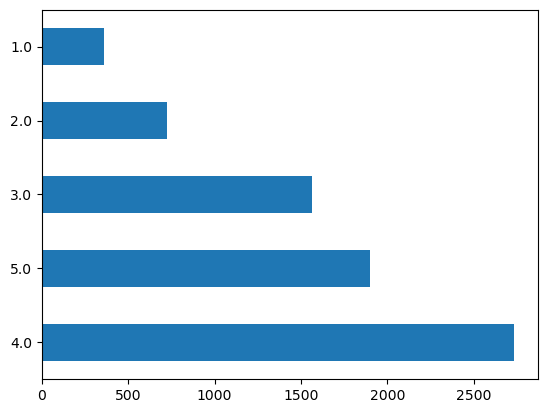

In [13]:
labor_df['Q85'].value_counts().plot(kind='barh')

Deal With Missing Values

In [ ]:
# drop rows with missing outcome data


In [ ]:
#calculate percent missing for column

In [ ]:
#proportion missing

In [ ]:
#plot histogram to check

In [ ]:
# drop rows with %missing above a certain threshold

RECODE MISSING VALUES

In [ ]:
# convert X to missing
#df = df.replace(r'X', np.nan, regex=True)
#or
#df = df.replace(r'X', 3, regex=True)

In [1]:
# put the columns in a list
df_columns = df.columns.tolist()

In [ ]:
#impute with mode (doesn't mess with distribution)

for impute_column in df_columns:
    test_df[impute_column].fillna(test_df[impute_column].mode()[0], inplace=True)

In [ ]:
#change type for numeric vars
numeric_vars = []

Create Dummies

In [2]:
#get dummies in a single column

In [ ]:
#add dummies back into dataframe

In [ ]:
#recode var
#test_df['q84'] = np.where(test_df['q84'].isin(['1', '2']),1,0]

In [ ]:
# you can create a list of variables and convert them in a loop
# need to make sure that you only use variables in the loop with the same responses
# and create a new dictionary and loop for other resposne patterns
# for variables with the following response format:
# 5	Strongly Agree
# 4	Agree
# 3	Neither Agree nor Disagree
# 2	Disagree
# 1	Strongly Disagree
# X	Do Not Know
dict_DNK = {'5':'5', '4':'4','3':'3', '2':'2', '1':'1','X':'3'}
# these are example variables
variables_to_convert = ['Q_1', 'Q_2', 'Q_3']
for variable in variables_to_convert:
    # replace missing value with most common value
    df[variable] = df[variable].fillna(df[variable].mode()[0])
    # convert X to middle value of scale
    df[variable] = df.replace({variable: dict_DNK},inplace=True)
    # convert variable to numeric
    df[variable]=df[variable].astype(int)

In [ ]:
#recode outcome variable to where stay is 0 and everything else is 1
#test_df['DLeaving'] = np.where(test_df['DLeaving']=='A'),0,1]

In [ ]:
#Select either the Department of Labor or the Department of Commerce dataframe and generate counts for each value and plot in bar charts along 
#with the count values either on the bar chart or a separate table.

In [ ]:
#Recode any variables where this is necessary. This must all be done in code because you will use the code to make the exact same changes to the second dataset later:
#

In [ ]:
#who does this predict poorly for
#how does it predict differently for 
#different sub-populations

#identify those it identifies correctly or incorrectly to 
#check for bias

#Key course parts for executing any project: Day 1 Supervised Learning: Activities 3 & 5; Day 2 Supervised Learning Activity 5; Day 2 Unsupervised Learning Activity 4